## Fine Tuning of Depth Anything

### Example documentation on NYUv2 dataset:
https://huggingface.co/blog/Isayoften/monocular-depth-estimation-guide

### Example notebook:
https://www.kaggle.com/code/amanattheedge/depth-anything-v2-metric-fine-tunning-on-nyu/notebook

### Clone Depth Anything V2 Github

In [1]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 142 (delta 31), reused 24 (delta 24), pack-reused 82 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
import sys
sys.path.append("./Depth-Anything-V2/metric_depth")

### Unzip image files and baseline checkpoint

In [4]:
!unzip ./depth_images_w_rgb.zip
!unzip ./checkpoints.zip

Streaming output truncated to the last 5000 lines.
  inflating: depth_images/depth_20251124_190055_307601.npy  
  inflating: depth_images/depth_20251124_190055_307601.png  
  inflating: depth_images/depth_20251124_190055_866903.npy  
  inflating: depth_images/depth_20251124_190055_866903.png  
  inflating: depth_images/depth_20251124_190056_463714.npy  
  inflating: depth_images/depth_20251124_190056_463714.png  
  inflating: depth_images/depth_20251124_190057_011073.npy  
  inflating: depth_images/depth_20251124_190057_011073.png  
  inflating: depth_images/depth_20251124_190057_528113.npy  
  inflating: depth_images/depth_20251124_190057_528113.png  
  inflating: depth_images/depth_20251124_190058_068827.npy  
  inflating: depth_images/depth_20251124_190058_068827.png  
  inflating: depth_images/depth_20251124_190058_606162.npy  
  inflating: depth_images/depth_20251124_190058_606162.png  
  inflating: depth_images/depth_20251124_190059_145671.npy  
  inflating: depth_images/depth_20

### Create Depth Dataset for Fine Tuning

In [5]:
# --------------------------
# Imports
# --------------------------
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import numpy as np

from depth_anything_v2.dpt import DepthAnythingV2
from util.loss import SiLogLoss
from dataset.transform import Resize  # minimal transform for resizing

# --------------------------
# Config
# --------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_FOLDER = "./depth_images"

BATCH_SIZE = 4

# --------------------------
# Dataset
# --------------------------
class DepthDataset(Dataset):
    def __init__(self, folder, transform=None, eps=1e-6):
        self.folder = folder
        self.rgb_files = sorted([f for f in os.listdir(folder) if f.startswith("rgb_") and f.endswith(".png")])
        self.depth_files = sorted([f for f in os.listdir(folder) if f.startswith("depth") and f.endswith(".npy")])
        self.transform = transform
        self.eps = eps

    def __len__(self):
        return len(self.rgb_files)

    def normalize_and_flip(self, depth):
        """Min-max normalize to [0,1] even with negatives, then flip."""
        d_min = np.min(depth)
        d_max = np.max(depth)
        depth_norm = (depth - d_min) / (d_max - d_min + self.eps)
        depth_flipped = 1.0 - depth_norm
        return depth_flipped

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.folder, self.rgb_files[idx])
        depth_path = os.path.join(self.folder, self.depth_files[idx])

        # Load RGB (BGR -> RGB)
        rgb = cv2.imread(rgb_path)[..., ::-1].astype(np.float32)

        # Load depth
        depth = np.load(depth_path).astype(np.float32)
        if depth.ndim == 3:
            depth = depth[..., 0]

        # Resize depth to match RGB
        depth = cv2.resize(depth, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_CUBIC)

        # Min-max normalize + flip
        depth = self.normalize_and_flip(depth)

        # Apply optional resize transform (affects both RGB + depth)
        sample = {'image': rgb, 'depth': depth}
        if self.transform:
            sample = self.transform(sample)

        # Convert to tensors
        rgb = sample['image'].astype(np.float32) / 255.0
        rgb = torch.tensor(rgb).permute(2, 0, 1).float()          # [3,H,W]
        depth = torch.tensor(sample['depth']).unsqueeze(0).float()  # [1,H,W]

        return rgb, depth



# Optional resize transform
transform = Resize(490, 644)
dataset = DepthDataset(DATA_FOLDER, transform=transform)

# Train/test split 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Sanity Checks for Dataset Dimensionality and Inputs

In [6]:
for rgb, depth in train_loader:
    print(f"RGB batch shape: {rgb.shape}, dtype: {rgb.dtype}")
    print(f"Depth batch shape: {depth.shape}, dtype: {depth.dtype}")
    break

RGB batch shape: torch.Size([4, 3, 644, 490]), dtype: torch.float32
Depth batch shape: torch.Size([4, 1, 644, 490]), dtype: torch.float32


In [7]:
rgb, depth = next(iter(train_loader))
print("RGB min/max:", rgb.min(), rgb.max())
print("Depth min/max:", depth.min(), depth.max())

# Check for invalid values
print("Depth contains zeros or negatives:", torch.any(depth <= 0).item())
print("Depth contains NaNs:", torch.any(torch.isnan(depth)).item())

RGB min/max: tensor(0.) tensor(1.0000)
Depth min/max: tensor(6.5565e-07) tensor(1.)
Depth contains zeros or negatives: False
Depth contains NaNs: False


torch.Size([1, 644, 490])
1.0 0.0


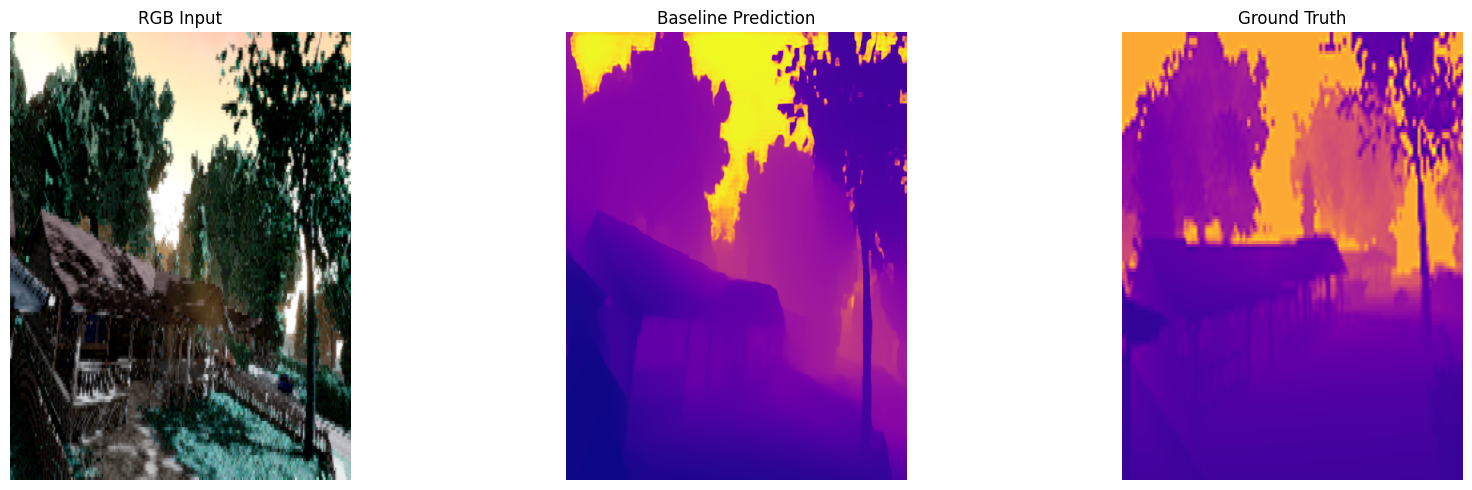

torch.Size([1, 644, 490])
1.0 0.0


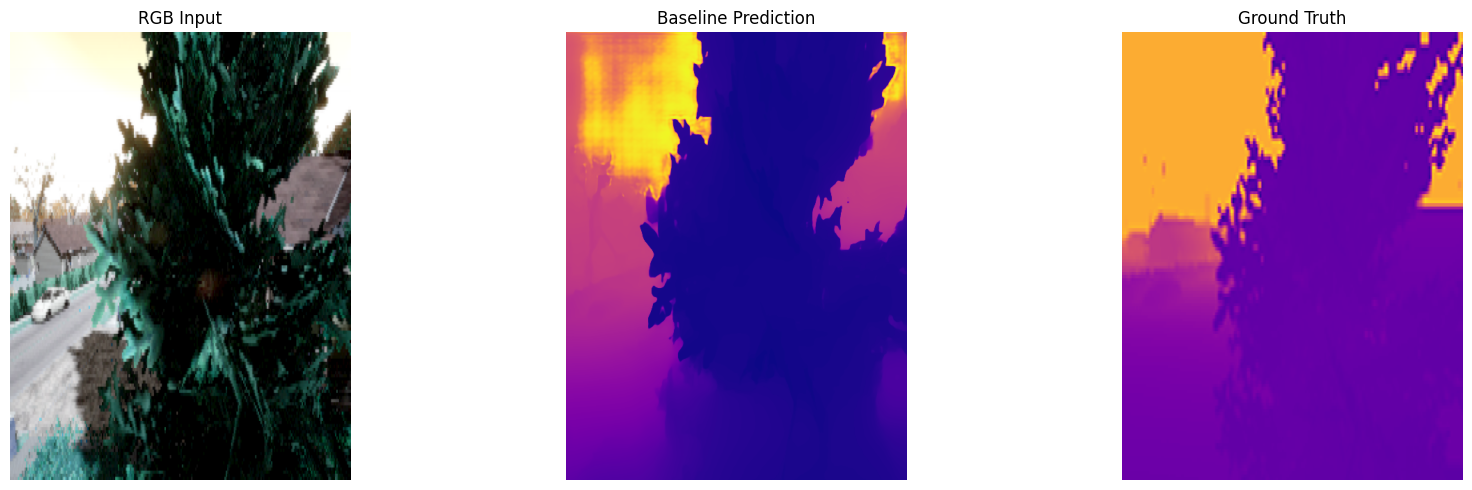

torch.Size([1, 644, 490])
1.0 0.0


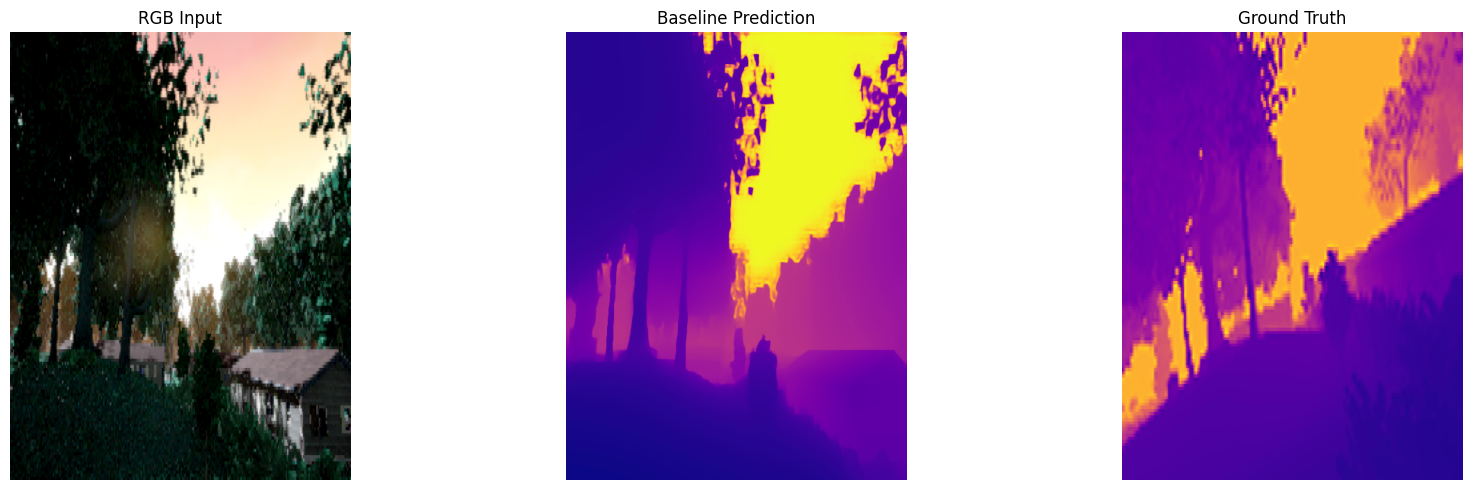

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
import random
import os

## hyperparameters
NUM_EPOCHS = 11
MODEL_WEIGHTS_PATH = "./checkpoints/depth_anything_v2_vits.pth"
SAVE_PATH = "./fine_tuning_results/depth_anything_v2_finetuned.pth"
LR = 5e-6
WEIGHT_DECAY = 0.01
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
}

device = DEVICE  # same device as training
num_examples = 8  # number of random examples
PATCH_SIZE = 14   # ViT patch size

# --------------------------
# Load models
# --------------------------

baseline_model = DepthAnythingV2(**model_configs['vits'])
baseline_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device, weights_only=True))
baseline_model.to(device).eval()

# --------------------------
# Helper functions
# --------------------------
EPS = 1e-6

def minmax_normalize(pred, eps=EPS):
    """Normalize array per-image to 0-1 and flip (1=near, 0=far)."""
    pred_min = pred.min()
    pred_max = pred.max()
    if pred_max - pred_min < eps:
        return np.zeros_like(pred)
    pred_norm = (pred - pred_min) / (pred_max - pred_min)
    return 1.0 - pred_norm  # flip so near=bright

# --------------------------
# Pick 3 random examples
# --------------------------
num_examples = 3
example_indices = random.sample(range(len(test_dataset)), num_examples)

for idx in example_indices:
    rgb, gt = test_dataset[idx]  # rgb [3,H,W], gt [1,H,W]
    rgb_np = (rgb.permute(1,2,0).numpy() * 255).astype(np.uint8)
    H_orig, W_orig = rgb_np.shape[:2]

    # Model input
    x_tensor = rgb.unsqueeze(0).float().to(device)  # [1,3,H,W]

    # --------------------------
    # Baseline prediction
    # --------------------------
    with torch.no_grad():
        base_pred = baseline_model(x_tensor)
        print(base_pred.shape)
        if base_pred.ndim == 3:
            base_pred = base_pred.unsqueeze(1)
        base_pred_np = minmax_normalize(base_pred.squeeze(0).squeeze(0).cpu().numpy())
        print(np.max(base_pred_np), np.min(base_pred_np))

    # --------------------------
    # Ground truth
    # --------------------------
    gt_np = minmax_normalize(gt.squeeze(0).cpu().numpy())
    # --------------------------
    # Plot RGB, baseline, and GT
    # --------------------------
    plt.figure(figsize=(18,5))

    plt.subplot(1,3,1)
    plt.imshow(rgb_np)
    plt.title("RGB Input")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(base_pred_np, cmap="plasma")
    plt.title("Baseline Prediction")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(gt_np, cmap="plasma")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Fine Tuning Depth Anything V2 Model

## Depth Evaluation Metrics

$\hat{d}_i$ and $d_i$ are clamped and normalized predicted and ground-truth depths, and $N $ is the number of valid pixels. Overall metrics are calculated as averaged across all pixels per image and then averaged all images.

### Absolute Relative Error (AbsRel)
$$
\text{AbsRel} = \frac{1}{N} \sum_{i=1}^{N} \frac{| \hat{d}_i - d_i |}{d_i}
$$

---

### Root Mean Squared Error (RMSE)
$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (\hat{d}_i - d_i)^2 }
$$

---

### Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |\hat{d}_i - d_i|
$$

---

### Scale-Invariant Logarithmic Error (SILog) Loss
$$
\text{SILog} =
\displaystyle \sqrt{
\underbrace{\frac{1}{N} \sum_{i=1}^{N} (\log \hat{d}_i - \log d_i)^2}_{\text{mean squared log difference}}
-
\frac{1}{2} \underbrace{\left( \frac{1}{N} \sum_{i=1}^{N} (\log \hat{d}_i - \log d_i) \right)^2}_{\text{bias correction term}}
}
$$

This scale-invariant loss is optimized by the fine-tuning training loop


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# --------------------------
# Hyperparameters
# --------------------------
EPS = 1e-6
NUM_EPOCHS = 11
LR = 5e-6
WEIGHT_DECAY = 0.01
MODEL_WEIGHTS_PATH = "./checkpoints/depth_anything_v2_vits.pth"
SAVE_PATH = "./fine_tuning_results/depth_anything_v2_finetuned.pth"

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
}

# --------------------------
# Initialize model
# --------------------------
model = DepthAnythingV2(**model_configs['vits'])
state = torch.load(MODEL_WEIGHTS_PATH, map_location='cpu')
# Load only encoder pretrained weights
model.load_state_dict({k: v for k, v in state.items() if 'pretrained' in k}, strict=False)
model = model.to(DEVICE)

# --------------------------
# Optimizer
# --------------------------
encoder_params = [p for n, p in model.named_parameters() if 'pretrained' in n]
decoder_params = [p for n, p in model.named_parameters() if 'pretrained' not in n]

optimizer = optim.AdamW([
    {'params': encoder_params, 'lr': LR},
    {'params': decoder_params, 'lr': LR*10}
], weight_decay=WEIGHT_DECAY)

criterion = SiLogLoss()  # your depth loss

# --------------------------
# Metrics
# --------------------------
def eval_depth(pred, target):
    """Compute standard depth metrics."""
    pred, target = pred.flatten(), target.flatten()
    thresh = torch.max(target / (pred + EPS), pred / (target + EPS))
    d1 = (thresh < 1.25).float().mean()
    diff = pred - target
    diff_log = torch.log(pred + EPS) - torch.log(target + EPS)
    abs_rel = torch.mean(torch.abs(diff)/target)
    rmse = torch.sqrt(torch.mean(diff**2))
    mae = torch.mean(torch.abs(diff))
    silog = torch.sqrt(diff_log.pow(2).mean() - 0.5*diff_log.mean().pow(2))
    return {'d1': d1.item(), 'abs_rel': abs_rel.item(), 'rmse': rmse.item(),
            'mae': mae.item(), 'silog': silog.item()}

# --------------------------
# Training Loop
# --------------------------
best_abs_rel = float('inf')
epoch_losses, epoch_abs_rel, epoch_rmse, epoch_mae = [], [], [], []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0

    for rgb, depth in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}"):
        optimizer.zero_grad()
        rgb, depth = rgb.to(DEVICE), depth.to(DEVICE).squeeze(1)  # already normalized [0,1]

        # Prediction
        pred = model(rgb).squeeze(1)
        pred = F.interpolate(pred[:, None], depth.shape[1:], mode='bilinear', align_corners=True).squeeze(1)

        mask = depth > 0
        if mask.sum() == 0:
            continue

        loss = criterion(pred, depth, mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # --------------------------
    # Validation
    # --------------------------
    model.eval()
    results = {'d1': 0, 'abs_rel': 0, 'rmse': 0, 'mae': 0, 'silog': 0}
    with torch.no_grad():
        for rgb, depth in test_loader:
            rgb, depth = rgb.to(DEVICE), depth.to(DEVICE).squeeze(1)
            pred = model(rgb).squeeze(1)
            pred = F.interpolate(pred[:, None], depth.shape[1:], mode='bilinear', align_corners=True).squeeze(1)

            mask = depth > 0
            if mask.sum() == 0:
                continue

            m = eval_depth(pred[mask], depth[mask])
            for k in results: results[k] += m[k]

    for k in results: results[k] /= len(test_loader)

    epoch_losses.append(avg_loss)
    epoch_abs_rel.append(results['abs_rel'])
    epoch_rmse.append(results['rmse'])
    epoch_mae.append(results['mae'])

    print(f"\nEpoch {epoch}/{NUM_EPOCHS} - Train Loss: {avg_loss:.4f} - Val Metrics: {results}")

print("\nTraining complete!")


Epoch 1/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 1/11 - Train Loss: 0.5436 - Val Metrics: {'d1': 0.6149112669321207, 'abs_rel': 16.524941327021672, 'rmse': 0.19815652485077198, 'mae': 0.13197461176377076, 'silog': 0.4121519817297275}


Epoch 2/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 2/11 - Train Loss: 0.4297 - Val Metrics: {'d1': 0.5122952006413386, 'abs_rel': 13.84122774215845, 'rmse': 0.20514294126859078, 'mae': 0.16056766702578618, 'silog': 0.41668582554046923}


Epoch 3/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 3/11 - Train Loss: 0.4133 - Val Metrics: {'d1': 0.6480082371601692, 'abs_rel': 17.016682753379527, 'rmse': 0.16558216166037779, 'mae': 0.11742990977489032, 'silog': 0.39664446395177105}


Epoch 4/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 4/11 - Train Loss: 0.4028 - Val Metrics: {'d1': 0.6519155003474308, 'abs_rel': 18.654861741432775, 'rmse': 0.16969953044102742, 'mae': 0.12365843371703074, 'silog': 0.4006663120251435}


Epoch 5/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 5/11 - Train Loss: 0.3913 - Val Metrics: {'d1': 0.6726359278880633, 'abs_rel': 17.975744411761944, 'rmse': 0.17343996460621175, 'mae': 0.12785352278214235, 'silog': 0.39703724783200484}


Epoch 6/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 6/11 - Train Loss: 0.3776 - Val Metrics: {'d1': 0.6891717470150728, 'abs_rel': 16.835658504229325, 'rmse': 0.1693876705949123, 'mae': 0.11617069765925407, 'silog': 0.4017858944489406}


Epoch 7/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 7/11 - Train Loss: 0.3609 - Val Metrics: {'d1': 0.6896091929765849, 'abs_rel': 18.24760200372109, 'rmse': 0.16841928289486813, 'mae': 0.11734511956572533, 'silog': 0.39942586944653435}


Epoch 8/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 8/11 - Train Loss: 0.3428 - Val Metrics: {'d1': 0.6872480852787312, 'abs_rel': 16.341055618066054, 'rmse': 0.17409776022801032, 'mae': 0.1169360541494993, 'silog': 0.40324880476181324}


Epoch 9/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 9/11 - Train Loss: 0.3298 - Val Metrics: {'d1': 0.6790747948793264, 'abs_rel': 15.900609352588653, 'rmse': 0.17776085560138408, 'mae': 0.12674564704298974, 'silog': 0.4039902944748218}


Epoch 10/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 10/11 - Train Loss: 0.3230 - Val Metrics: {'d1': 0.7209790636942937, 'abs_rel': 17.19533166683637, 'rmse': 0.16718711733818054, 'mae': 0.11130490709955876, 'silog': 0.40298464316588184}


Epoch 11/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 11/11 - Train Loss: 0.3128 - Val Metrics: {'d1': 0.6286399618937419, 'abs_rel': 15.06771914427097, 'rmse': 0.18862431306105393, 'mae': 0.14249575939316017, 'silog': 0.41411006588202254}

Training complete!


#### Save Fine-tuned model

In [11]:
import os
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), SAVE_PATH)
print(f"✔ Saved fine-tuned model to {SAVE_PATH}")

✔ Saved fine-tuned model to ./fine_tuning_results/depth_anything_v2_finetuned.pth


### Plot avg training loss and test set metric curves

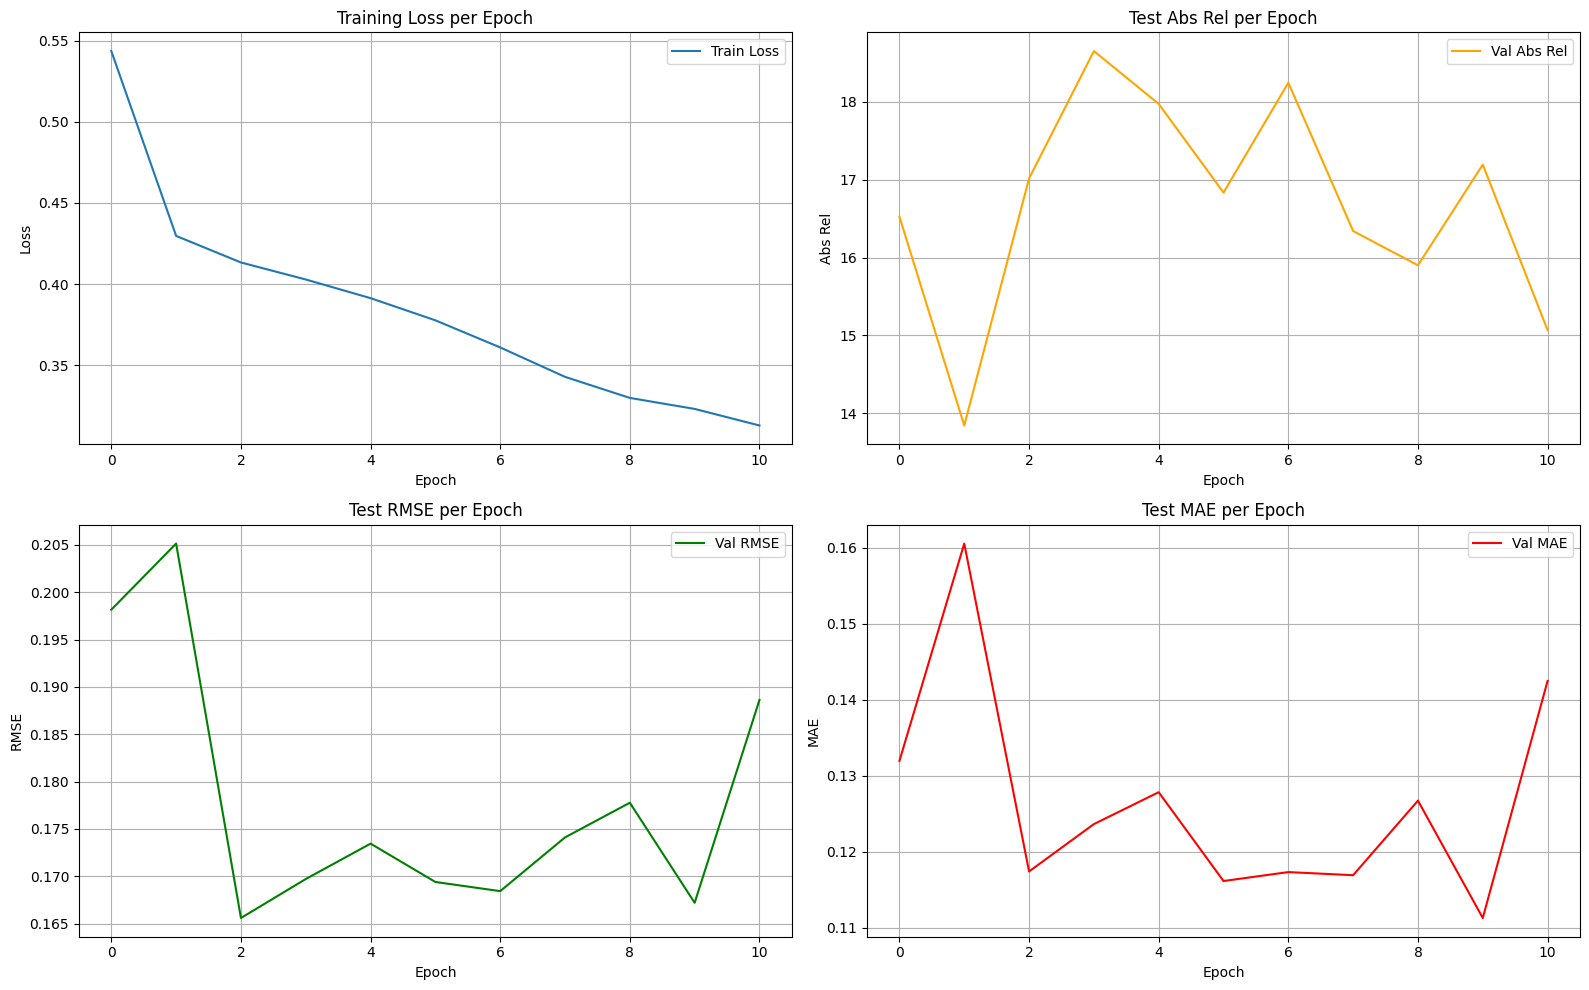

In [12]:
# --------------------------------------------------------------------------
# Plot loss + MSE curves
# --------------------------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))

# -------------------------
# 1. Training Loss
# -------------------------
plt.subplot(2,2,1)
plt.plot(epoch_losses, label="Train Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# -------------------------
# 2. Abs Rel
# -------------------------
plt.subplot(2,2,2)
plt.plot(epoch_abs_rel, label="Val Abs Rel", color='orange')
plt.title("Test Abs Rel per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Abs Rel")
plt.grid(True)
plt.legend()

# -------------------------
# 3. RMSE
# -------------------------
plt.subplot(2,2,3)
plt.plot(epoch_rmse, label="Val RMSE", color='green')
plt.title("Test RMSE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()

# -------------------------
# 4. MAE
# -------------------------
plt.subplot(2,2,4)
plt.plot(epoch_mae, label="Val MAE", color='red')
plt.title("Test MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("./fine_tuning_results/training_curves.png", dpi=150)
plt.show()

#### Write training performance vs epoch to csv for reference

In [13]:
import pandas as pd
# Build a DataFrame containing all metrics
training_metrics_df = pd.DataFrame({
    "epoch": list(range(1, NUM_EPOCHS + 1)),
    "train_loss": epoch_losses,
    "test_abs_rel": epoch_abs_rel,
    "test_rmse": epoch_rmse,
    "test_mae": epoch_mae,
})
training_metrics_df

epoch  train_loss  test_abs_rel  test_rmse  test_mae
0       1    0.543572     16.524941   0.198157  0.131975
1       2    0.429658     13.841228   0.205143  0.160568
2       3    0.413280     17.016683   0.165582  0.117430
3       4    0.402789     18.654862   0.169700  0.123658
4       5    0.391293     17.975744   0.173440  0.127854
5       6    0.377628     16.835659   0.169388  0.116171
6       7    0.360922     18.247602   0.168419  0.117345
7       8    0.342790     16.341056   0.174098  0.116936
8       9    0.329815     15.900609   0.177761  0.126746
9      10    0.323028     17.195332   0.167187  0.111305
10     11    0.312814     15.067719   0.188624  0.142496

In [14]:
# Save to CSV
csv_path = "./fine_tuning_results/training_metrics.csv"
training_metrics_df.to_csv(csv_path, index=False)

print(f"✔ Saved metrics to {csv_path}")

✔ Saved metrics to ./fine_tuning_results/training_metrics.csv


In [ ]:
!unzip ./fine_tuning_results.zip

Archive:  ./fine_tuning_results.zip
   creating: fine_tuning_results/
  inflating: fine_tuning_results/comparison_pred_114.png  
  inflating: __MACOSX/fine_tuning_results/._comparison_pred_114.png  
  inflating: fine_tuning_results/comparison_pred_71.png  
  inflating: __MACOSX/fine_tuning_results/._comparison_pred_71.png  
  inflating: fine_tuning_results/overall_metrics.csv  
  inflating: __MACOSX/fine_tuning_results/._overall_metrics.csv  
  inflating: fine_tuning_results/comparison_pred_12.png  
  inflating: __MACOSX/fine_tuning_results/._comparison_pred_12.png  
  inflating: fine_tuning_results/training_curves.png  
  inflating: __MACOSX/fine_tuning_results/._training_curves.png  
  inflating: fine_tuning_results/comparison_pred_140.png  
  inflating: __MACOSX/fine_tuning_results/._comparison_pred_140.png  
  inflating: fine_tuning_results/training_metrics.csv  
  inflating: __MACOSX/fine_tuning_results/._training_metrics.csv  
  inflating: fine_tuning_results/depth_anything_v2_fi

#### Compare input, baseline prediction, fine-tuned prediction, and ground truth for several input images

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
import random
import os

## hyperparameters
EPS = 1e-6
MODEL_WEIGHTS_PATH = "./checkpoints/depth_anything_v2_vits.pth"
SAVE_PATH = "./fine_tuning_results/depth_anything_v2_finetuned.pth"
LR = 5e-6
WEIGHT_DECAY = 0.01
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
}

# --------------------------
# Config
# --------------------------
device = DEVICE  # same device as training
num_examples = 8  # number of random examples
PATCH_SIZE = 14   # ViT patch size

# --------------------------
# Load models
# --------------------------
#ft_model = DepthAnythingV2(**model_configs['vits'])
#ft_model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
#ft_model.to(device).eval()

baseline_model = DepthAnythingV2(**model_configs['vits'])
baseline_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device, weights_only=True))
baseline_model.to(device).eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    

In [16]:
state = torch.load(MODEL_WEIGHTS_PATH, map_location=device)
missing, unexpected = ft_model.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

Missing keys: []
Unexpected keys: []


19.982254 0.7910905
2.7006025 0.15265433


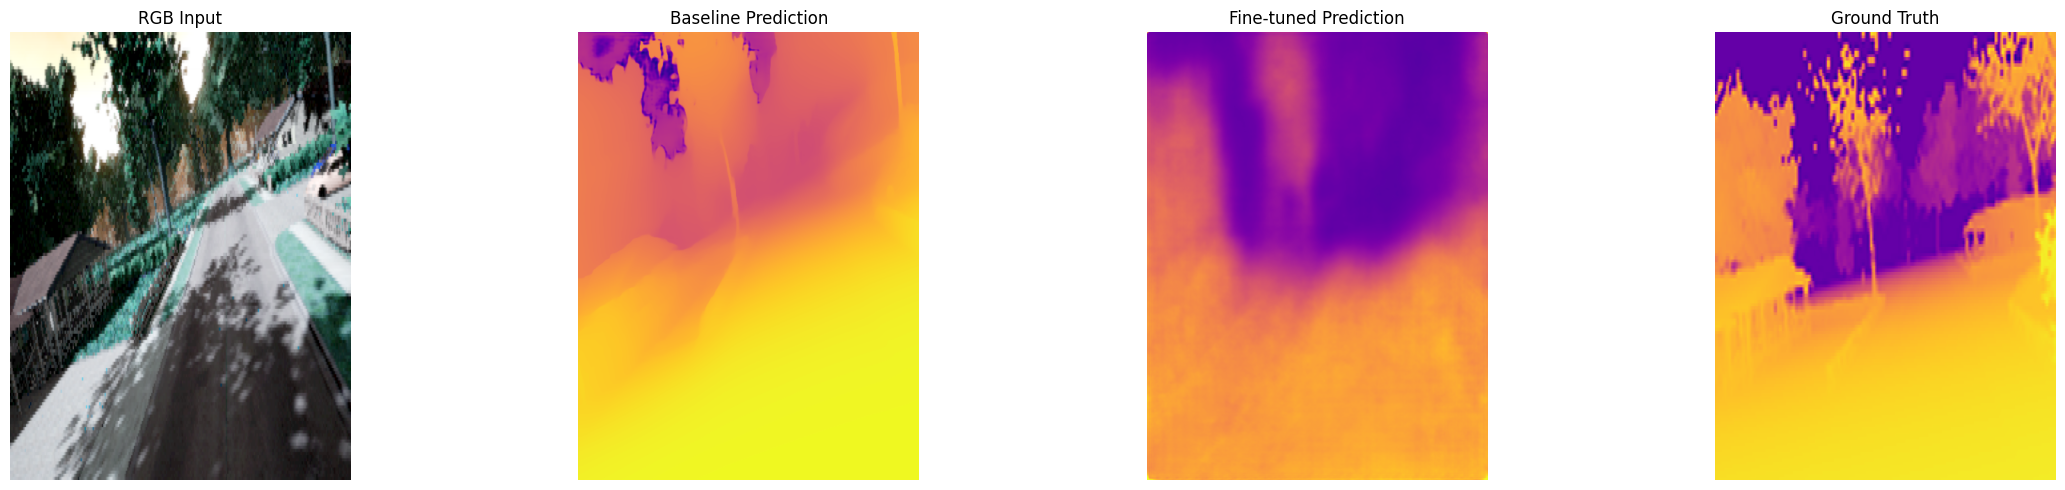

19.614502 0.008206219
2.6176572 0.14560404


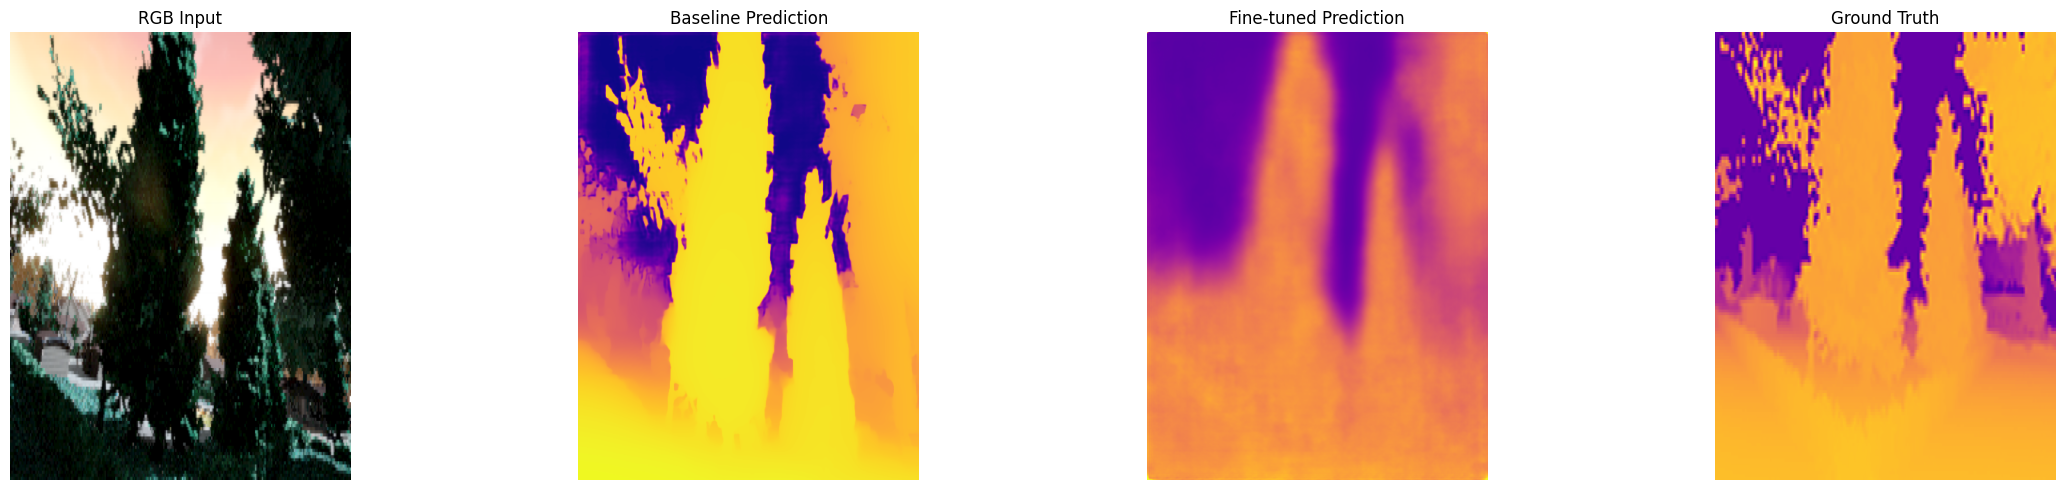

19.959501 0.09377431
2.8319445 0.1546656


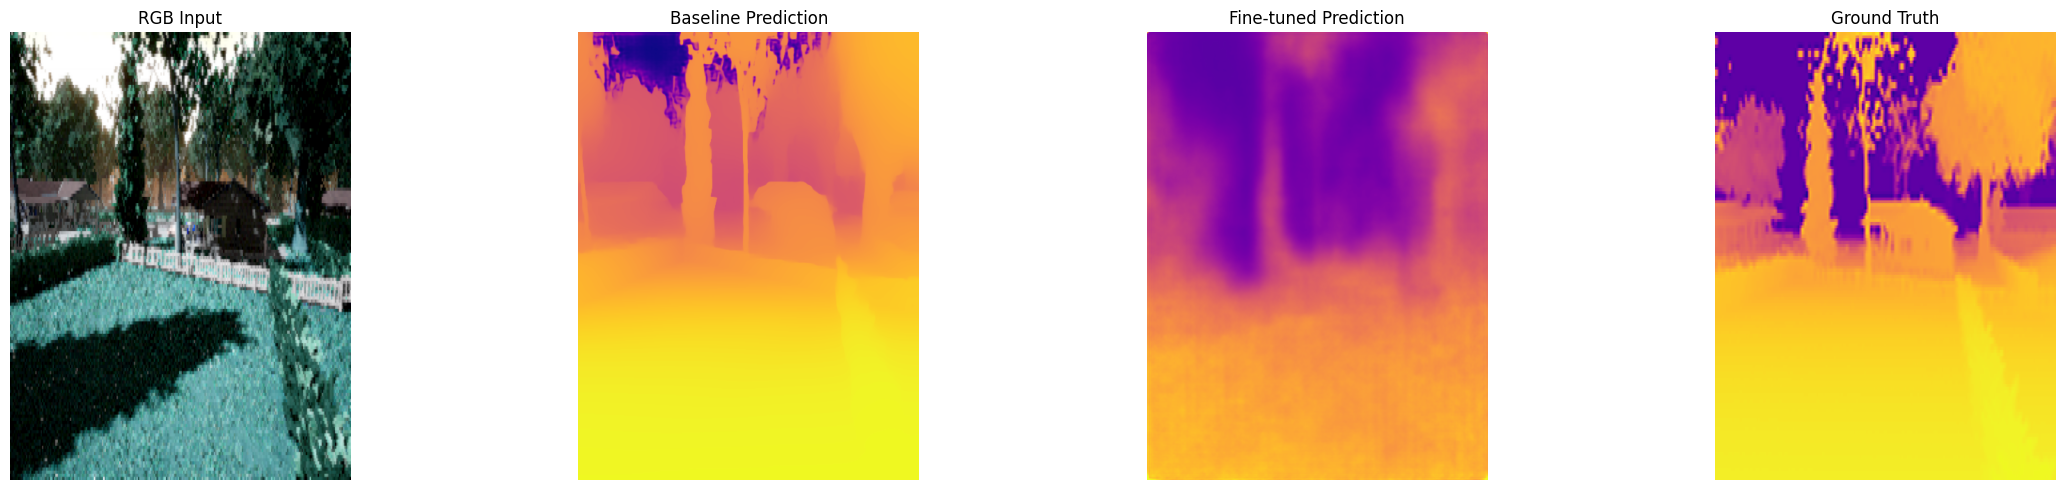

In [26]:


num_examples = 3
example_indices = random.sample(range(len(test_dataset)), num_examples)

for idx in example_indices:
    rgb, gt = test_dataset[idx]  # rgb [3,H,W], gt [1,H,W]
    rgb_np = (rgb.permute(1,2,0).numpy() * 255).astype(np.uint8)

    # Model input
    x_tensor = rgb.unsqueeze(0).float().to(device)  # [1,3,H,W]

    # --------------------------
    # Baseline prediction
    # --------------------------
    with torch.no_grad():
        base_pred = baseline_model(x_tensor)
        if base_pred.ndim == 3:
            base_pred = base_pred.unsqueeze(1)
        base_pred_np = base_pred.squeeze(0).squeeze(0).cpu().numpy()

    # --------------------------
    # Fine-tuned prediction
    # --------------------------
    with torch.no_grad():
        ft_pred = model(x_tensor)
        if ft_pred.ndim == 3:
            ft_pred = ft_pred.unsqueeze(1)
        ft_pred_np = ft_pred.squeeze(0).squeeze(0).cpu().numpy()

    # --------------------------
    # Ground truth
    # --------------------------
    gt_np = gt.squeeze(0).cpu().numpy()  # already normalized
    print(np.max(base_pred_np), np.min(base_pred_np))
    print(np.max(ft_pred_np), np.min(ft_pred_np))
    # --------------------------
    # Plot RGB, baseline, fine-tuned, and GT
    # --------------------------
    plt.figure(figsize=(24,5))

    plt.subplot(1,4,1)
    plt.imshow(rgb_np)
    plt.title("RGB Input")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(base_pred_np, cmap="plasma")
    plt.title("Baseline Prediction")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(ft_pred_np, cmap="plasma", vmin=0, vmax=1)
    plt.title("Fine-tuned Prediction")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(gt_np, cmap="plasma")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"./fine_tuning_results/comparison_pred_{idx}.png", dpi=150)
    plt.show()


#### Evaluate overall training set and test set performance using relevant metrics, comparing baseline model to fine-tuned model

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

EPS = 1e-6

# --------------------------------------------------
# Metric calculation
# --------------------------------------------------
def compute_metrics(pred, gt, eps=EPS):
    """Compute AbsRel, RMSE, MAE, SiLog for single image."""
    mask = gt > eps
    pred_masked = pred[mask]
    gt_masked = gt[mask]

    abs_rel = np.mean(np.abs(pred_masked - gt_masked) / gt_masked)
    rmse = np.sqrt(np.mean((pred_masked - gt_masked)**2))
    mae = np.mean(np.abs(pred_masked - gt_masked))

    d = np.log(pred_masked + eps) - np.log(gt_masked + eps)
    silog = np.sqrt(np.mean(d**2) - (np.mean(d)**2)) * 100

    return abs_rel, rmse, mae, silog

# --------------------------------------------------
# Dataset evaluation
# --------------------------------------------------
def evaluate_dataset(dataset, model, device, N=None):
    """Evaluate model on dataset. Returns mean metrics."""
    results = []
    total = len(dataset) if N is None else min(N, len(dataset))

    model.eval()
    with torch.no_grad():
        for idx in range(total):
            rgb, gt = dataset[idx]  # rgb [3,H,W], gt [1,H,W]
            x = rgb.unsqueeze(0).float().to(device)

            pred = model(x)
            if pred.ndim == 3:
                pred = pred.unsqueeze(1)
            pred = F.interpolate(pred, size=gt.shape[1:], mode='bilinear', align_corners=True)
            pred_np = pred.squeeze(0).squeeze(0).cpu().numpy()
            gt_np = gt.squeeze(0).cpu().numpy()

            abs_rel, rmse, mae, silog = compute_metrics(pred_np, gt_np)
            results.append([abs_rel, rmse, mae, silog])

    results = np.array(results)
    mean_metrics = results.mean(axis=0)
    return mean_metrics

# --------------------------------------------------
# Run evaluation for all models & splits
# --------------------------------------------------
metrics_data = []

for model_name, model_obj in zip(["baseline", "finetuned"], [baseline_model, model]):
    for split_name, dataset in zip(["train", "test"], [train_dataset, test_dataset]):
        mean_metrics = evaluate_dataset(dataset, model_obj, device)
        metrics_data.append([model_name, split_name, *mean_metrics])

# --------------------------------------------------
# Save results in DataFrame and CSV
# --------------------------------------------------
df_metrics = pd.DataFrame(metrics_data, columns=["model", "split", "AbsRel", "RMSE", "MAE", "SiLog"])
save_path = "./fine_tuning_results/metrics_comparison.csv"
df_metrics.to_csv(save_path, index=False)

print(df_metrics)
print(f"\nSaved metrics comparison to {save_path}")

       model  split     AbsRel       RMSE        MAE       SiLog
0   baseline  train  27.454203  15.029533  13.946119  108.199814
1   baseline   test  28.019964  14.998397  13.940536  108.259377
2  finetuned  train   0.255060   0.147855   0.113015   28.899496
3  finetuned   test   0.350212   0.188612   0.142489   38.805534

Saved metrics comparison to ./fine_tuning_results/metrics_comparison.csv
